# 룰 기반 필터링

## 사용 라이브러리

In [1]:
import pandas as pd
import re
import pandas as pd
from collections import defaultdict
from kiwipiepy import Kiwi
from tqdm import tqdm
import matplotlib.pyplot as plt

## 리뷰 불러오기 & 전처리

In [4]:
def clean_text(sent, remove_tag = True):
    """
    특수 문자, 문장 부호, 조건 태그 제거
    """
    if remove_tag:
        sent = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s0-9a-zA-Z]", " ", sent)
    else:
        sent = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s0-9a-zA-Z<>]", " ", sent)
    sent = re.sub("[ㄱ-ㅎㅏ-ㅣ]+", "", sent) # 초성체 제거
    sent = " ".join(sent.split()) # 공백 최소화
    sent = sent.strip()
    return sent

In [5]:
# df = pd.read_csv("/opt/ml/input/data/reviews_ver2_1.csv")
# df = pd.read_csv("/opt/ml/input/data/reviews_ver3_1.csv")
# df = pd.read_csv("/opt/ml/input/data/reviews_ver6.csv")
df = pd.read_csv("/opt/ml/input/data/reviews_ver31.csv") # 데이터 엄청 많음
df["context"] = df["context"].apply(lambda x: clean_text(x))
print(df.keys())
print(len(df))

Index(['review_id', 'prod_id', 'prod_name', 'rating', 'title', 'context',
       'answer', 'review_url', 'helped_cnt', 'create_date', 'top100_yn',
       'sentiment', 'keywords', 'search_caterory', 'survey'],
      dtype='object')
77078


### db table 여러개 합치기

In [6]:
dfs = [
    pd.read_csv("/opt/ml/input/data/reviews_ver2_1.csv"),
    pd.read_csv("/opt/ml/input/data/reviews_ver3_1.csv"),
    pd.read_csv("/opt/ml/input/data/reviews_ver6.csv"),
    pd.read_csv("/opt/ml/input/data/reviews_ver31.csv")
    ]

for df in dfs:
   df["context"] = df["context"].apply(lambda x: clean_text(x))

In [7]:
"""각 db table에 prod_id 값 겹치는 것이 있으므로 고유한 번호로 바꾸기"""

prod_id_maps = [
    dict() for _ in dfs
]

prod_num = 0

for df_idx, df in enumerate(dfs):
    for i in df["prod_id"].unique():
        prod_num += 1
        prod_id_maps[df_idx][i] = prod_num

    dfs[df_idx]["prod_id"] = dfs[df_idx]["prod_id"].apply(lambda x: prod_id_maps[df_idx][x])

df = pd.concat(dfs)

print([len(d) for d in dfs], "->", len(df))

[200, 200, 2044, 77078] -> 79522


## 문장 단위로 분리하기

In [8]:
# kiwi = Kiwi(model_type='sbg', typos='basic') # 1368문장 18초
kiwi = Kiwi() # 200리뷰 1354문장 3초 -> 한 상품 20리뷰 0.15 초
# kiwi = Kiwi(model_type="sbg") # 1368문장 4초
# kiwi = Kiwi(typos="basic") # 1356문장 16초

corpus = []
for item in tqdm(df.itertuples(), total=len(df), desc="Splitting reviews"):
    sents = kiwi.split_into_sents(
        item.context, 
        normalize_coda=True, 
        split_complex=True,
    ) # 반환: [Sentence(text, start, end, tokens, subs)]
    for sent in sents:
        text = str(item.prod_id) + " " + sent.text
        corpus.append(text)

Splitting reviews: 100%|██████████| 79522/79522 [15:45<00:00, 84.08it/s] 


In [9]:
print(f"문장 개수: {len(corpus)}, 글자 수(공백 제외): {sum([len(re.sub(' ', '', c)) for c in corpus])}")
print(corpus[0])

문장 개수: 452884, 글자 수(공백 제외): 18409995
1 추억의 국민학교 떡볶이 오리지널 냉동 600g 2개 후기 배송날짜 23년 04월 24일 유통기한 24년 03월 20일 주문하여 로켓 프레시 배송으로 신선하게 배송되었어요


## 룰 기반 필터링

In [10]:
def compress_score(before_len, after_len):
    perc = (1 - after_len/before_len)*100
    print(f"{before_len} -> {after_len}, 삭제 개수: {before_len - after_len}, 필터링 비율: {perc: .02f}%")
    return perc

In [11]:
def check_patterns(patterns, corpus, highlight=True):
    save_dict = dict()

    for idx, text in tqdm(enumerate(corpus), total=len(corpus), desc="Checking patterns"):
        to_save = False
        for k in patterns:
            res = re.search(k, text)
            if res:
                to_save = True
                if highlight: text = text[:res.start()] + "[" + res.group() + "]" + text[res.end():]
        if to_save: 
            save_dict[idx] = text

    return save_dict

In [12]:
def filter_length(corpus, min_len=10, max_len=200, include_blank = False):
    filtered_corpus = [text for text in tqdm(corpus, total=len(corpus), desc="Filtering too short sentences")
                       if (
                           (include_blank and len(text) >= min_len)
                           or (not include_blank and len(re.sub(" ", "", text)) >= min_len)
                       )]
    short_len = len(corpus) - len(filtered_corpus)
    
    filtered_corpus = [text for text in tqdm(filtered_corpus, total=len(filtered_corpus), desc="Filtering too long sentences") 
                       if(
                           (include_blank and len(text) <= max_len)
                           or (not include_blank and len(re.sub(" ", "", text)) <= max_len)
                       )]
    long_len = len(corpus) - len(filtered_corpus)
    
    print(f"Shorter than {min_len}: {short_len} | Longer than {max_len}: {long_len}")
    return filtered_corpus

In [13]:
pre_len = len(corpus)
filtered_corpus = filter_length(corpus, 10, 200)
compress_score(pre_len, len(filtered_corpus))

Filtering too long sentences: 100%|██████████| 439755/439755 [00:01<00:00, 282537.07it/s]

Shorter than 10: 13129 | Longer than 200: 13992
452884 -> 438892, 삭제 개수: 13992, 필터링 비율:  3.09%


3.0895328605117456

In [14]:
# 해당 정규식 패턴이 들어가면 문장 삭제

del_patterns = [
    "조리", "해동", "요리", '추가','[센중약]불', "넣", "헹", # 레시피
    # "에어[ ]?[프후]라이[기어]?", "오븐", "전자레인지", "[^ ]*팬", "냄비",
    '작성', '도움', '내돈내산','리뷰','안녕','보답','감사','눌러','좋은 하루', "후기", # 리뷰 끝맺음
    "(유통)?기한", 
    "(재)?구매", "(재)?구입",
    "배달", "배송", "로켓", "프레시",'주문',
]

pre_len = len(filtered_corpus)
del_dict = check_patterns(del_patterns, filtered_corpus)
filtered_corpus = [text for idx, text 
                   in tqdm(enumerate(filtered_corpus), total=len(filtered_corpus), desc="Filtering corpus")
                   if not del_dict.get(idx)]

print(compress_score(pre_len, len(filtered_corpus)))

print(list(del_dict.values())[0])

Filtering corpus: 100%|██████████| 438892/438892 [00:00<00:00, 1081544.11it/s]

438892 -> 268038, 삭제 개수: 170854, 필터링 비율:  38.93%
38.92848354492677
1 추억의 국민학교 떡볶이 오리지널 냉동 600g 2개 [후기] [배송]날짜 23년 04월 24일 [유통기한] 24년 03월 20일 [주문]하여 [로켓] [프레시] 배송으로 신선하게 배송되었어요


## 상품별 리뷰 복원

In [15]:
sents_dict = defaultdict(list)
for text in filtered_corpus:
    idx = text.split()[0]
    text = text[len(idx)+1:]
    sents_dict[int(idx)].append(text)

reviews_dict = dict()
for prod_id, sents in sents_dict.items():
    reviews_dict[int(prod_id)] = ". ".join(sents)

len(reviews_dict.keys())

4357

In [16]:
"""필터 전 문서"""

ori_sents_dict = defaultdict(list)
for text in corpus:
    idx = text.split()[0]
    text = text[len(idx)+1:]
    ori_sents_dict[int(idx)].append(text)

ori_reviews_dict = dict()
for prod_id, sents in ori_sents_dict.items():
    ori_reviews_dict[int(prod_id)] = ". ".join(sents)

len(ori_reviews_dict.keys())

4369

## 삭제된 상품 확인

In [17]:
del_prods = []

for key in ori_reviews_dict.keys():
    if not reviews_dict.get(key): del_prods.append(key)

print(f"삭제된 상품 {len(del_prods)} 개 {del_prods}")
print()

for prod_id in del_prods:
    print("===", prod_id, "===")
    print(ori_reviews_dict[prod_id])

삭제된 상품 12 개 [1865, 2234, 2650, 2651, 2667, 3017, 3157, 3245, 3264, 3272, 3273, 3305]

=== 1865 ===
튼 살 크림에 섞어 바르려고 구매했어요 크림만으론 부족한 느낌이었는데 오일 추가하니 더 오래 촉촉한 느낌이에요
=== 2234 ===
맛있어요. 근데 너무너무 달아요 주둥이가 작아서 컵에 부을 때 요리조리 돌리면서 요령이 좀 필요함. 안 그럼 주둥이 바깥으로 흘러내림 재구매를 망설이게 하는 단 한 가지 이유는 너무 달다는 거
=== 2650 ===
피 쿠션 리필이 다 되어서 리필 구입했는데 역시 좋아요 봄철 건조해져서 적당히 촉촉한 쿠션 원하신다면 구입하시면 좋을 것 같아요
=== 2651 ===
피 쿠션 리필이 다 되어서 리필 구입했는데 역시 좋아요 봄철 건조해져서 적당히 촉촉한 쿠션 원하신다면 구입하시면 좋을 것 같아요
=== 2667 ===
유통기한이 한 달도 안 되는 너무 짧은 제품이었어요 치킨무 맛은 그럭저럭 먹을만했는데 아무래도 유통기한이 너무 짧아서 진짜 실망 다 버렸습니다. 아까워라
=== 3017 ===
시래기도 부드럽고 갈치 쌀밥이 두둑하고 양도 넉넉해요 떡 있던 거 추가해서 먹으니 맛있어요 물만 붓고 졸이면 되니 세상 편하고 맛있어요
=== 3157 ===
햄버거 소스 만들려고 구매했어요. 치폴레소스 오픈하면 소스랑 치폴레 건고추가 같이 들어 있어요 그냥 먹기엔 너무 맵고 다른 소스 만들 때 같이 섞어서 사용하시면 좋아요. 저는 믹서기에 마요네즈랑 허브들 넣고 같이 갈아줬어요. 품절이 자주 되는 상품이라 품절 아닐 때 빨리 구매하는 편이에요
=== 3245 ===
그동안 계속 사 세 텐더 사용해서 보통 사이즈를 알고 있는데 급해서 쿠팡으로 구매했습니다. 작아도 너무너무 작아요 한 봉지만 그런 게 아니라 10봉지 다 작아요 집에서 가정용으로 구매하시는 분들은 괜찮을 거 같고 판매용으로 구매하시는 분들은 사이즈 참고하시면 좋을 거 같아요
=== 3264 ===
빠에야인 

## 상품별 리뷰 길이 확인

In [18]:
"""상품별 리뷰 길이 변화"""

print("=== corpus 압축률 ===")
print(compress_score(len(corpus), len(filtered_corpus)))
print()

print("=== 상품별 리뷰 글자수(공백 제외) 변화 ===")
ori_len_list = []
len_list = []
for prod_id in reviews_dict.keys():
    len_list.append(len(re.sub(' ', '',reviews_dict[prod_id])))
    ori_len_list.append(len(re.sub(' ','',ori_reviews_dict[prod_id])))
    print(f"상품 {prod_id}: {len(re.sub(' ','',ori_reviews_dict[prod_id]))} -> {len(re.sub(' ', '',reviews_dict[prod_id]))}")
    
print(f"필터링 후 상품 별 리뷰 길이: 평균 {sum(len_list) / len(len_list)}, 최대 {max(len_list)}, 최소 {min(len_list)}")

=== corpus 압축률 ===
452884 -> 268038, 삭제 개수: 184846, 필터링 비율:  40.82%
40.81530811421909

=== 상품별 리뷰 글자수(공백 제외) 변화 ===
상품 1: 5591 -> 1253
상품 2: 6492 -> 1968
상품 3: 5531 -> 2109
상품 4: 4868 -> 2307
상품 5: 3607 -> 1687
상품 6: 4698 -> 1676
상품 7: 4967 -> 1960
상품 8: 4797 -> 2009
상품 9: 3704 -> 1276
상품 10: 5531 -> 2145
상품 11: 5686 -> 3126
상품 12: 4937 -> 2556
상품 13: 6862 -> 3431
상품 14: 5461 -> 2664
상품 15: 3493 -> 2529
상품 16: 5929 -> 2682
상품 17: 3872 -> 1915
상품 18: 6259 -> 3337
상품 19: 4490 -> 2345
상품 20: 5199 -> 2916
상품 21: 6192 -> 2599
상품 22: 5103 -> 2455
상품 23: 6339 -> 2863
상품 24: 3896 -> 2048
상품 25: 3403 -> 1796
상품 26: 5564 -> 3351
상품 27: 5084 -> 2204
상품 28: 5260 -> 2637
상품 29: 5103 -> 2455
상품 30: 2236 -> 1477
상품 31: 4372 -> 1987
상품 32: 3778 -> 1976
상품 33: 4394 -> 2067
상품 34: 4625 -> 3100
상품 35: 820 -> 626
상품 36: 910 -> 431
상품 37: 255 -> 119
상품 38: 4625 -> 3100
상품 39: 361 -> 245
상품 40: 360 -> 196
상품 41: 4617 -> 2240
상품 42: 6221 -> 3613
상품 43: 6251 -> 2854
상품 44: 3840 -> 2381
상품 45: 5547 -> 3431
상품 

In [19]:
len([l for l in len_list if l < 50])

83

In [20]:
print(sorted(len_list))

[6, 7, 9, 9, 11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 14, 15, 15, 15, 18, 18, 19, 20, 20, 22, 24, 25, 26, 26, 26, 27, 27, 28, 28, 28, 29, 29, 29, 29, 29, 31, 31, 33, 34, 34, 35, 35, 36, 36, 37, 37, 37, 39, 39, 39, 40, 41, 41, 41, 41, 42, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 45, 45, 46, 47, 48, 48, 48, 48, 49, 49, 50, 50, 50, 51, 52, 53, 54, 54, 54, 56, 58, 59, 59, 61, 61, 62, 63, 64, 64, 64, 64, 65, 65, 65, 65, 66, 68, 69, 69, 69, 71, 71, 73, 76, 76, 76, 76, 78, 78, 78, 78, 79, 81, 81, 82, 83, 83, 84, 84, 85, 85, 87, 87, 87, 88, 88, 90, 91, 93, 93, 94, 94, 94, 95, 96, 96, 97, 97, 98, 98, 99, 99, 101, 102, 102, 107, 108, 108, 109, 110, 110, 110, 113, 113, 113, 113, 113, 113, 113, 116, 116, 117, 117, 119, 119, 119, 119, 121, 121, 122, 124, 124, 127, 129, 129, 130, 131, 131, 132, 133, 135, 136, 138, 138, 138, 138, 139, 140, 140, 142, 143, 144, 144, 144, 144, 144, 145, 147, 147, 148, 148, 148, 148, 148, 151, 151, 153, 153, 153, 153, 154, 154, 154, 154, 155, 157, 157, 158, 161

### 히스토그램

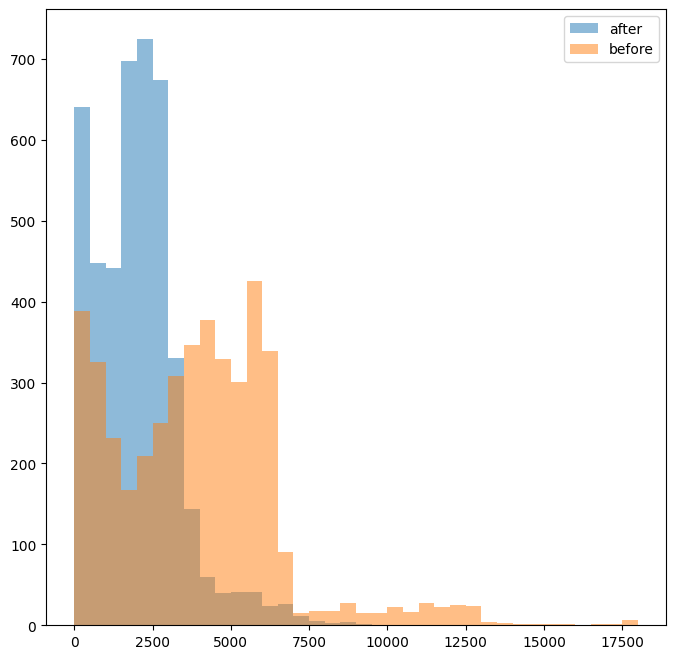

In [35]:
left = min(len_list + ori_len_list)
left = left // 100 * 100
right = max(len_list + ori_len_list)
right = (right // 100 + 1) * 100

bins = range(left, right, 500)

plt.figure(figsize=(8,8))

plt.hist(len_list, bins, alpha=0.5, label="after")
plt.hist(ori_len_list, bins, alpha=0.5, label="before")
plt.legend(loc="upper right")
plt.show()